In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize 

# Environment Setup

In [2]:
class StochasticPricingEnvironment:
    """
    Stochastic environment for dynamic pricing with customer valuation uncertainty.
    
    This environment simulates a single-product pricing scenario where:
    - Customers have valuations drawn from a known distribution
    - The probability of purchase depends on whether customer valuation >= price
    - Each round represents one customer interaction
    """
    def __init__(self, valuation_distribution):
        """
        Initialize the pricing environment.
        
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
        """
        self.valuation_dist = valuation_distribution
        
    def demand_probability(self, price):
        """
        Calculate the theoretical probability that a customer purchases at given price.
        
        This is the complement of the CDF: P(valuation >= price) = 1 - F(price)
        where F is the cumulative distribution function of customer valuations.
        
        Args:
            price: The price to evaluate
            
        Returns:
            Probability that a randomly drawn customer will purchase at this price
        """
        return 1 - self.valuation_dist.cdf(price)

    def simulate_round(self, price):
        """
        Simulate one customer interaction at the given price.
        
        Args:
            price: The price offered to the customer
            
        Returns:
            tuple: (sale_made, revenue) where:
                - sale_made: 1 if customer purchased, 0 otherwise
                - revenue: price if sale was made, 0 otherwise
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue

# Agent Setup

In [20]:
class UCBLikeAgent:
    """
    UCB1-based agent for dynamic pricing with inventory constraints.
    
    This agent implements a variant of the UCB1 algorithm adapted for:
    1. Dynamic pricing (instead of traditional MAB rewards)
    2. Inventory constraints (limited number of products to sell)
    3. Dual optimization: maximize revenue while respecting inventory constraint
    
    The algorithm maintains upper confidence bounds on revenue (f_UCB) and 
    lower confidence bounds on demand probability (c_LCB), then solves a 
    linear program to find the optimal price distribution.
    """
    
    def __init__(self, P, T, prices, confidence_bound=1, rho_penalty=1.0, use_pen_rho=True):
        """
        Initialize the UCB agent for constrained dynamic pricing.
        
        Args:
            P: Total inventory (number of products available)
            T: Time horizon (number of rounds)
            prices: List of available prices to choose from
            confidence_bound: Confidence parameter for UCB/LCB bounds
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
        """
        k = len(prices)

        # Environment parameters
        self.use_pen_rho=use_pen_rho
        self.prices = prices  # Available price options
        self.K = k           # Number of price arms
        self.T = T           # Total number of rounds
        self.confidence_bound = confidence_bound  # UCB confidence parameter
        
        # Current state
        self.current_price_idx = None  # Index of currently selected price
        self.t = 0                     # Current round number
        
        # Statistics for each price arm
        self.avg_revenue = np.zeros(k)  # Average revenue per price
        self.avg_demand = np.zeros(k)   # Average demand probability per price
        self.N_pulls = np.zeros(k)      # Number of times each price was selected
        
        # Inventory management
        self.inventory = P               # Initial inventory
        self.remaining_inventory = P     # Current remaining inventory
        self.rho = P / T                # Target selling rate
        self.rho_penalty = rho_penalty  # Penalty factor for inventory constraint
        
        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'inventory': []   # Inventory levels over time
        }
    
    def select_price(self):
        """
        Select the next price using UCB1 with inventory constraints.
        
        Strategy:
        1. If inventory is empty, return NaN (no meaningful price)
        2. First K rounds: explore each price once (initialization)
        3. Subsequent rounds: solve LP with UCB revenue bounds and LCB demand bounds
        
        Returns:
            Selected price, or np.nan if no inventory remaining
        """
        # No inventory left - cannot make meaningful pricing decisions
        if self.remaining_inventory < 1:
            self.current_price_idx = np.argmax(self.prices)  # Arbitrary selection
            return np.nan
            
        # Exploration phase: try each price at least once
        if self.t < self.K:
            self.current_price_idx = self.t
        # Exploitation-Exploration phase: use UCB with inventory constraints
        
        else:            
            # Compute upper confidence bounds on revenue for each price
            confidence_radius = self.confidence_bound * np.sqrt(2 * np.log(self.t) / np.maximum(self.N_pulls, 1))
            f_ucbs = self.avg_revenue + confidence_radius
            
            demand_confidence_radius = self.confidence_bound * np.sqrt(2 * np.log(self.t) / np.maximum(self.N_pulls, 1))
            c_lcbs = np.maximum(0,self.avg_demand - demand_confidence_radius)
            
            # Solve linear program to get optimal price distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            
            # Sample price according to computed distribution
            self.current_price_idx = np.random.choice(self.K, p=gamma_t)

        return self.prices[self.current_price_idx]

    def compute_opt(self, f_ucbs, c_lcbs): 
        """
        Solve constrained optimization problem to find optimal price distribution.
        
        Formulation:
        maximize: sum_i gamma_i * f_ucb_i (expected revenue)
        subject to: sum_i gamma_i * c_lcb_i <= rho_penalty * current_rho (inventory constraint)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)
        
        where current_rho is the required selling rate to use remaining inventory.
        
        Args:
            f_ucbs: Upper confidence bounds on revenue for each price
            c_lcbs: Lower confidence bounds on demand probability for each price
            
        Returns:
            gamma: Probability distribution over prices
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(c_lcbs <= 1e-10):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma
        
        # Convert to minimization problem (negate revenues)
        c = -f_ucbs
        
        # Compute current required selling rate
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory / remaining_rounds, 0)
        
        # Linear program constraints
        A_ub = [c_lcbs]      # Inventory constraint coefficients
        
        if self.use_pen_rho:
            
            # Apply penalty to make constraint more conservative, but not too tight
            # If inventory is high relative to time remaining, relax the constraint
            inventory_ratio = self.remaining_inventory / self.inventory
            time_ratio = (self.T - self.t) / self.T
            
            if inventory_ratio > 0.5 and time_ratio > 0.5:
                # Early stages with plenty of inventory: relax constraint
                penalty_factor = self.rho_penalty * 1.5
            elif inventory_ratio < 0.1:
                # Low inventory: tighten constraint
                penalty_factor = self.rho_penalty * 0.5
            else:
                penalty_factor = self.rho_penalty
                
            penalized_rho = current_rho * penalty_factor
            
            # If the constraint is too tight (lower than minimum demand), relax it
            min_demand = np.min(c_lcbs[c_lcbs > 0]) if np.any(c_lcbs > 0) else 0
            
            if penalized_rho < min_demand * 0.5:
                penalized_rho = min_demand * 0.8
            
            b_ub = [penalized_rho]       # Inventory constraint bound
        
        
        else:

            b_ub = [current_rho]       # Inventory constraint bound

        A_eq = [np.ones(self.K)]     # Probability constraint coefficients  
        b_eq = [1]                   # Probability constraint bound
        
        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.K) / self.K
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.K) / self.K
        except:
            # Fallback: uniform distribution
            return np.ones(self.K) / self.K
    
    def update(self, reward, purchased):
        """
        Update agent's statistics based on observed outcome.
        
        Args:
            reward: Revenue obtained (price if purchased, 0 otherwise)
            purchased: Boolean indicating if purchase was made
        """
        idx = self.current_price_idx
        
        # Update pull count
        self.N_pulls[idx] += 1
        
        # Update average revenue using incremental mean formula
        self.avg_revenue[idx] += (reward - self.avg_revenue[idx]) / self.N_pulls[idx]
        
        # Update average demand probability
        purchased_indicator = 1.0 if purchased else 0.0
        self.avg_demand[idx] += (purchased_indicator - self.avg_demand[idx]) / self.N_pulls[idx]
        
        # Update inventory only if purchase was actually made and inventory available
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
        elif purchased and self.remaining_inventory <= 0:
            # This shouldn't happen with proper price selection, but handle gracefully
            reward = 0
            purchased = False
        
        # Record history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        
        # Increment time
        self.t += 1

    def get_best_price(self):
        """
        Return the price with highest average revenue observed so far.
        
        Returns:
            tuple: (best_price, best_average_revenue)
        """
        best_idx = np.argmax(self.avg_revenue)
        return self.prices[best_idx], self.avg_revenue[best_idx]

# Theoretical Optimal


In [21]:
#define the optimal solution
def compute_clairvoyant(prices, environment, T, P):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information.
    
    This function solves the linear program that an oracle with perfect knowledge
    of the demand probabilities would solve:
    
    maximize: sum_i gamma_i * price_i * demand_prob_i
    subject to: sum_i gamma_i * demand_prob_i <= P/T  (inventory constraint)
               sum_i gamma_i = 1                      (probability constraint)
               gamma_i >= 0                          (non-negativity)
    
    Args:
        prices: List of available prices
        environment: StochasticPricingEnvironment to get true demand probabilities
        T: Time horizon
        P: Total inventory
        
    Returns:
        tuple: (optimal_distribution, optimal_value, demand_probabilities, expected_revenues)
    """
    # Compute true demand probabilities for each price
    buying_probabilities = np.array([environment.demand_probability(p) for p in prices])
    
    # Expected revenue per selection for each price
    exp_reward= prices * buying_probabilities
    
    # Set up linear program (convert maximization to minimization)
    c = -exp_reward  # Negate for minimization
    
    # Inventory constraint: expected consumption rate <= inventory rate
    A_ub = [buying_probabilities]
    b_ub = [P / T]
    
    # Probability constraint: sum of probabilities = 1
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    # Solve the linear program
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,method='highs', 
                          bounds=[(0, 1) for _ in range(len(prices))])
    
    gamma = res.x  # Optimal price distribution
    optimal_value = -(res.fun)  # Optimal expected revenue per round
    
    return gamma, optimal_value, buying_probabilities, exp_reward

# Simulation

In [22]:
def run_simulator(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=1,
    verbose=True
):
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_prices = []
    first_inventory_empty = None

    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env_theoretical,
        T=agent_params['T'],
        P=agent_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    #optimal_revenue = np.dot(agent_params['prices'], opt_dist)
    #optimal_revenue = np.dot(true_rewards, opt_dist)
    optimal_revenue=opt_value
    for sim in range(n_simulations):
        
        print(f"\n=== Running UCB1 Pricing Simulation #{sim + 1} for {T} rounds ===")

        # Create environment and agent
        env = StochasticPricingEnvironment(
            valuation_distribution=valuation_dist
        )
        agent = UCBLikeAgent(**agent_params)
        #agent = ThompsonSamplingAgent(P =agent_params['P'], T=T, prices=agent_params['prices'], rho_penalty=agent_params['rho_penalty'])

        for t in range(T):
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                print(f"Inventory empty for the first time at round {t}")
                print("No more products in the inventory")

            price = agent.select_price()
            price_idx = agent.current_price_idx

            if agent.remaining_inventory <= 0:
                sale_made = False
                revenue = 0
            else:
                sale_made, revenue = env.simulate_round(price)

            agent.update(revenue, sale_made)

            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)
                    # Print progress occasionally
            if verbose and (t + 1) % (T // 10) == 0:
                remaining_inventory = np.sum(agent.remaining_inventory)
                print(f"Round {t + 1:4d}: Revenue = {revenue:6.2f}, "
                    f"Cumulative = {total_revenue:8.2f}, "
                    f"Remaining inventory = {remaining_inventory:.0f}")



        best_price, best_avg_revenue = agent.get_best_price()
        best_prices.append(best_price)

        print(f"\nSimulation completed!")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")
        print(f"Theoretical optimal: {opt_dist} (expected revenue: {optimal_revenue:.2f})")

    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = [price_to_idx[p] for p in selected_prices if not np.isnan(p)]
    price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))        

    if verbose:
        print("\n=== Simulation Results ===")
        print("\nPrice selection frequency:")
        for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
            percentage = 100 * count / T
            marker = " ← OPTIMAL" if i == optimal_idx else ""
            print(f"  Price {price:2}: {count:4d} times ({percentage:5.1f}%){marker}")

    return {
        'price_counts': price_counts,
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_prices': best_prices,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        'opt_dist': opt_dist,
        'optimal_idx': optimal_idx,
        'optimal_revenue': optimal_revenue,
        'agent': agent  # Add the final agent state
    }


# Run the simulation

In [32]:
# Environment Configuration
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.15,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

#valuation_dist=stats.uniform(0,1)

T = 100000 # Number of rounds
inventory = T*0.7 # Inventory constraint

n_prices=4

# Calculate epsilon for exploration
epsilon = inventory**(-1/3)  # Epsilon for UCB exploration

agent_params = {
    'P': inventory,  # inventory constraint
    'T': T,  # number of rounds
    #'prices': [0.0,0.1,0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1],  # set of prices 
    'prices': np.linspace(0.1, 0.9, n_prices+2),  # set of prices 
    'confidence_bound': 1,  # UCB exploration parameter (reduced for better performance)
    'rho_penalty': 1,  # Penalty factor for inventory constraint (increased to allow more sales)
    'use_pen_rho': False  # Use rho penalty for inventory constraint
}

agent = UCBLikeAgent(**agent_params)

#print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")
print(f'Inventory contrain: ',agent_params['P'])
print(f'Number of rounds:',agent_params['T'])

# set random seed for reproducibility
np.random.seed(42)

results = run_simulator(
    T=T,
    valuation_dist=valuation_dist,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=True
)

selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_prices = results['best_prices']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
price_counts = results['price_counts']
agent = results['agent']  # Get the actual agent used in simulation

Number of price options: 6
UCB confidence bound: 1
Inventory contrain:  70000.0
Number of rounds: 100000

=== Running UCB1 Pricing Simulation #1 for 100000 rounds ===
Round 10000: Revenue =   0.26, Cumulative =  2615.38, Remaining inventory = 62995
Round 20000: Revenue =   0.00, Cumulative =  5463.54, Remaining inventory = 55851
Round 30000: Revenue =   0.42, Cumulative =  8335.60, Remaining inventory = 48740
Round 40000: Revenue =   0.42, Cumulative = 11234.22, Remaining inventory = 41645
Round 50000: Revenue =   0.42, Cumulative = 14144.54, Remaining inventory = 34585
Round 60000: Revenue =   0.42, Cumulative = 17066.02, Remaining inventory = 27511
Round 70000: Revenue =   0.42, Cumulative = 20042.06, Remaining inventory = 20389
Round 80000: Revenue =   0.00, Cumulative = 22922.58, Remaining inventory = 13507
Round 90000: Revenue =   0.42, Cumulative = 25850.10, Remaining inventory = 6563
Inventory empty for the first time at round 99996
No more products in the inventory
Round 100000

# Plot the results

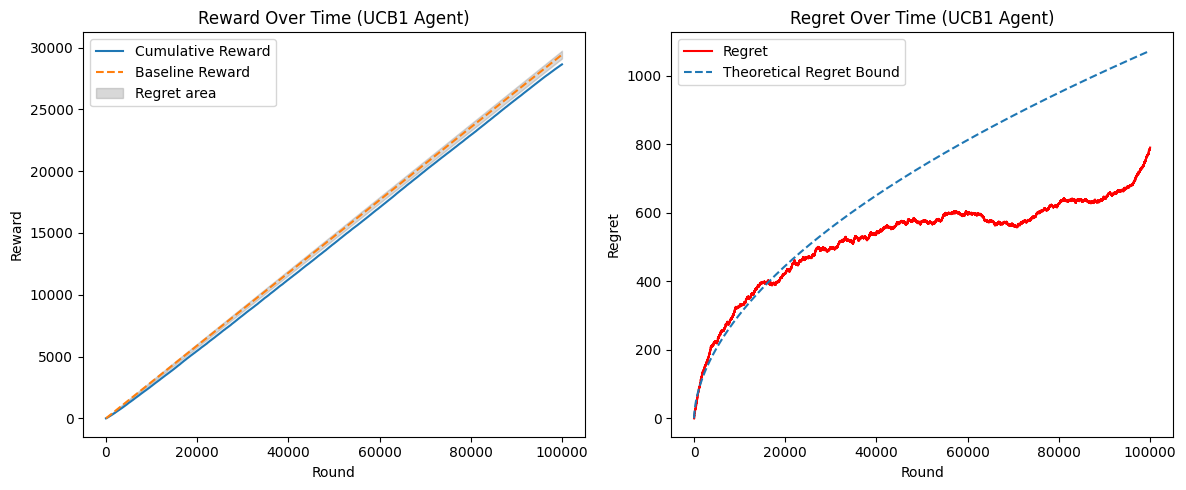

In [33]:
_, opt_value, _, _ = compute_clairvoyant(
    prices=agent_params['prices'],
    environment=StochasticPricingEnvironment(valuation_distribution=valuation_dist),
    T=agent_params['T'],
    P=agent_params['P']
)

baseline_reward_invetory = [opt_value * (t + 1) for t in range(T)]
regret_invetory = np.array(baseline_reward_invetory) - cumulative_revenue

t_vals = np.arange(1, T + 1)
theoretical_bound = np.sqrt(np.log(t_vals) * t_vals)
# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_revenue, label="Cumulative Reward")
plt.plot(baseline_reward_invetory, label="Baseline Reward", linestyle="--")
t_values = np.arange(T)
plt.fill_between(t_values, baseline_reward_invetory-np.sqrt(t_values), baseline_reward_invetory+np.sqrt(t_values), color='gray', alpha=0.3, label="Regret area")
plt.xlabel("Round")
plt.ylabel("Reward")
plt.title("Reward Over Time (UCB1 Agent)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regret_invetory, label="Regret", color='red')
plt.plot(theoretical_bound, label="Theoretical Regret Bound", linestyle="--")
plt.xlabel("Round")
plt.ylabel("Regret")
plt.title("Regret Over Time (UCB1 Agent)")
plt.legend()

plt.tight_layout()
plt.show()